In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS, Predictive
from src.data.data_loader import default_em, load_uplift
from src.data.preprocessing import (
    detrend,
    ffnn_input_vector,
    interval_outlier,
    load_thickness_time_series,
)
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import FFNN, compute_love_numbers, greens_function

from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
import pyro.contrib.gp as gp
from pyro.nn.module import PyroParam, pyro_method

print(PROJECT_ROOT)
pyro.set_rng_seed(42)


def compute_error(trues, predicted):
    """
    From course material
    """
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues) ** 2))
    return corr, mae, rae, rmse

/data/eigil/work/premis


Load uplift data from two GNET (Greenland GPS Network) stations and height data from Kuaqalissuaq glacier. The time series from GNET and height data from ISSM are sampled weekly. The height data is further preprocessed with an interval outlier removal method to remove unrealistic peaks.

In [2]:
df_em = default_em()

df = load_uplift(timefreq="W")
df = df.set_index("Time")
df_tmp = df.copy()
# df_tmp = df_tmp.set_index("Time")
df.Thickness = (
    interval_outlier(df_tmp, M_step=24, max_std=2)
    .Thickness.interpolate()
    .fillna(method="bfill")
    .values
)

height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


KeyboardInterrupt: 

### Prepare data and split in train / test
The data prepared here does not only include the first model, but all later models as well. But what data is accessed depends on the chapter/model. This can be seen as how our work has progressed throughout project.

In [ ]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.index.month.to_series(index=df.index)], axis=1)
df1.columns = [*df1.columns[:-1], "Month"]
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [ ]:
standardized_height = height - np.mean(height)  # / np.std(height)
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X = torch.tensor(X_cat).float()

y1 = torch.tensor(detrend(up_kuaq)).float()
y1 = y1 - y1.mean()  # / y_train1.std()

y2 = torch.tensor(detrend(up_mik2)).float()
y2 = y2 - y2.mean()  # / y_train2.std()

y = torch.vstack([y1, y2]).T

In [ ]:
train_perc = 0.80  # percentage of training data
split_point = int(train_perc * len(y))
X_train = X[:split_point, :]
X_test = X[split_point:, :]
y_train = y[:split_point]
y_test = y[split_point:]

time_train = df.index[:split_point]
time_test = df.index[split_point:]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 435
num test: 109


## load neural network to estimate love numbers

In [ ]:
df_params, x = ffnn_input_vector(
    df_em, path="../data/processed/ffnn_variable_normalisation_params_512.csv"
)

ffnn = FFNN(31, 200, 513)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../models/ffnn_v2.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=513, bias=True)
  (relu): ReLU()
)

## GP inference on thickness time series

In [ ]:
y_t = -X_train[:, 0].double()
X_t = torch.linspace(0, 1, len(y_t)).double()
# y_t = (y_t - y_t.mean())/y_t.std()

# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(30), lengthscale=torch.tensor(0.15), period=torch.tensor(0.1)
)
# gpr = gp.models.GPRegression(X_t, y_t, kernel, noise=torch.tensor(0.5))
Xu = torch.arange(100.0).double() / 100
gpr = gp.models.SparseGPRegression(X_t, y_t, kernel, Xu=Xu, noise=torch.tensor(20), jitter=1e-5)

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.8))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 0.6))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 3000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

corr = 0.6030445080905669, 
mae = 56.593676877868575, 
rae = 0.9094853953213295, 
rmse = 76.26044059025976
corr = 0.33357444912667583, 
mae = 112.74681621976384, 
rae = 1.0074279165735314, 
rmse = 143.96938105491924


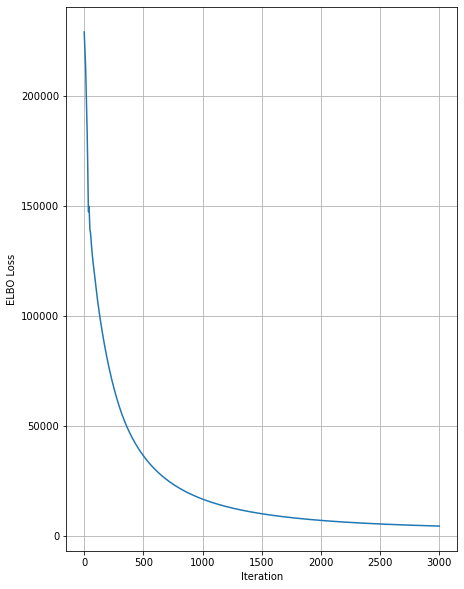

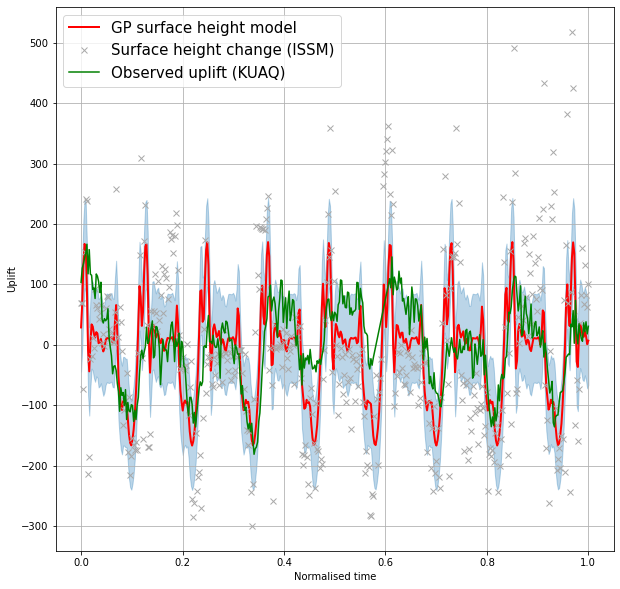

In [ ]:
plt.figure(figsize=(7, 10))
plt.plot(losses)
plt.xlabel("Iteration", fontsize=10)
plt.ylabel("ELBO Loss", fontsize=10)
plt.grid()
plt.savefig("./GP_loss.png", dpi=400)

plt.figure(figsize=(10, 10))
ax = plt.gca()
uplift = y_train[:, 0].numpy()
T_test = torch.linspace(0, 1, len(uplift)).double()  # test inputs
# plot(T_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[0, 1])
mean, cov = gpr(T_test, full_cov=True, noiseless=False)
sd = cov.diag().sqrt()  # standard deviation at each input point x

with torch.no_grad():
    ax.plot(T_test.numpy(), mean.numpy(), "r", lw=2, label="GP surface height model")  # plot the mean
    ax.fill_between(
        T_test.numpy(),  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd).numpy(),
        (mean + 2.0 * sd).numpy(),
        color="C0",
        alpha=0.3,
    )

plt.plot(T_test, y, linestyle="None", marker="x", label="Surface height change (ISSM)", color="darkgrey")
plt.plot(T_test, 10 * uplift, label="Observed uplift, scaled (KUAQ)", color="green")
plt.xlabel("Normalised time", fontsize=10)
plt.ylabel("Uplift", fontsize=10)
plt.grid()
plt.legend(fontsize=15)
plt.savefig("./GP_spregression.png", dpi=400)

preds = gpr(T_test, full_cov=True)[0].detach()
corr, mae, rae, rmse = compute_error(preds.numpy(), uplift)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")
corr, mae, rae, rmse = compute_error(y.numpy(), uplift) # (upl - np.mean(upl)) / np.std(upl)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

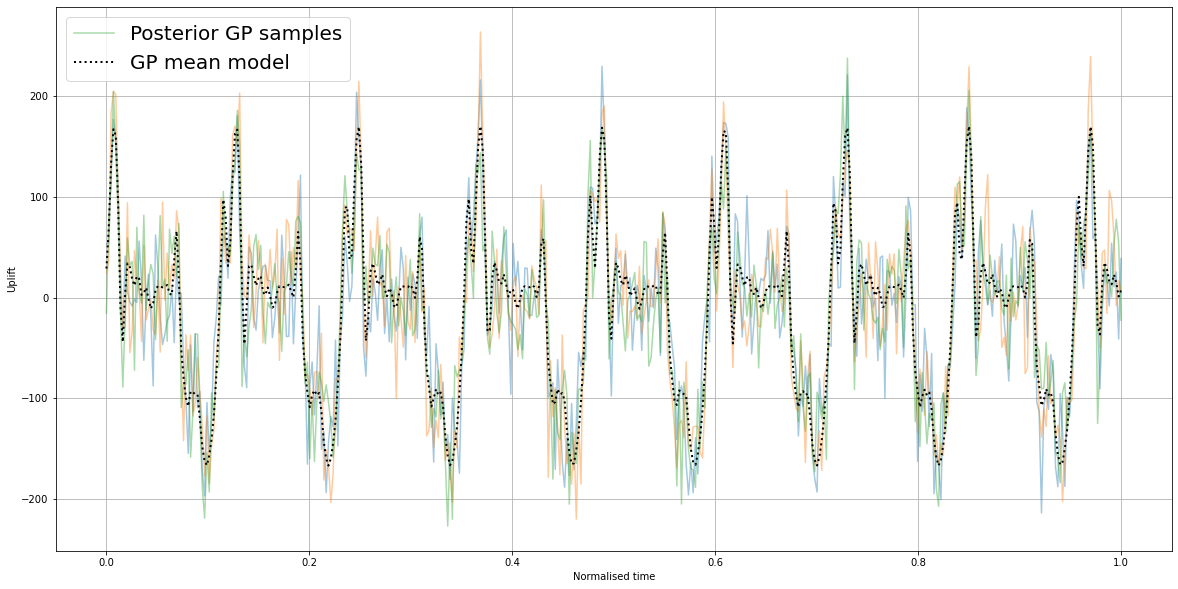

In [ ]:
plt.figure(figsize=(20,10))
mean, cov = gpr(T_test, full_cov=True, noiseless=False)
for i in range(2):
    with torch.no_grad():
        sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
        plt.plot(T_test, sample, alpha=0.4)
        
sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
plt.plot(T_test, sample.detach(), alpha=0.4, label="Posterior GP samples")
plt.plot(T_test, mean.detach(), "black", lw=2, linestyle=":", label="GP mean model", alpha=1)
plt.xlabel("Normalised time")
plt.ylabel("Uplift")
plt.grid()
plt.legend(fontsize=20)
plt.savefig("./GP_posterior_samples.png", dpi=400)


In [ ]:
mean, cov = gpr(T_test, full_cov=True, noiseless=False)

In [ ]:
def model(X, x, df_params, mean_v=None, cov_v=None, obs=None, df_em=None):
    N = len(X)
    K = 2
    seasonality = 12 # months
    
    # seasonality modelling
    alpha_s = pyro.sample("alpha_s", dist.Normal(0., 1.))
    sigma_s = pyro.sample("sigma_s", dist.Normal(torch.zeros(seasonality, 2), torch.ones(seasonality, 2)))

    rigidity_1 = pyro.sample("rigidity_1", dist.LogNormal(24.12 * torch.ones(1), 0.5))
    rigidity_2 = pyro.sample("rigidity_2", dist.LogNormal(24.4 * torch.ones(1), 0.5))
    
    dh = pyro.sample("dh", dist.MultivariateNormal(mean_v.float(), cov_v.float()))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)

    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )

    gf = pyro.deterministic("gf", 5e1 * torch.tensor([gf_kuaq, gf_mik2]))
    
    # Draw target
    with pyro.plate("data", K):
        w = pyro.sample(
            "w", dist.Normal(gf * dh[..., None], torch.exp(alpha_s + X[:, 1:].matmul(sigma_s))), obs=obs
        )
    return w

In [ ]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
# mcmc.run(X_train, x, df_params, y_train, df_em)
mcmc.run(X_train, x, df_params, mean_v=mean, cov_v=cov, obs=y_train, df_em=df_em)

Sample: 100%|██████████| 1100/1100 [20:18,  1.11s/it, step size=1.15e-01, acc. prob=0.864]


In [ ]:
import dill
#save mcmc object
with open('final_model_v3.pkl', 'wb') as f:
	dill.dump(mcmc, f)

In [ ]:
# Show summary of inference results
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_s      1.78      0.21      1.78      1.41      2.11    232.92      1.01
        dh[0]     18.75     38.12     18.39    -39.54     83.46   1932.76      1.00
        dh[1]     54.26     37.53     54.29     -4.64    118.05   1541.82      1.00
        dh[2]    114.61     38.14    113.80     50.02    177.31   1083.77      1.00
        dh[3]    147.29     36.87    146.81     92.84    217.22   1100.58      1.00
        dh[4]    146.50     34.45    147.06     87.06    202.53   1256.74      1.00
        dh[5]     79.89     35.37     81.18     16.06    133.88   2403.02      1.00
        dh[6]    -17.77     36.71    -17.92    -79.74     36.63   1830.04      1.00
        dh[7]    -54.28     40.05    -54.34   -116.11     18.14   1365.41      1.00
        dh[8]    -14.85     36.00    -15.22    -72.94     44.36   2523.20      1.00
        dh[9]     14.71     35.63     13.66    -48.07     70.08   2314.06  

In [ ]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3  # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_0 = np.mean(1 / 15 * (A[0] + C[0] - 2 * F[0] + 5 * N[0] + 6 * L[0]))
prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(
    1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6])
)
prem_rigidity = {
    "rigidity_0": prem_rigidity_0 * 1e8,
    "rigidity_1": prem_rigidity_1 * 1e8,
    "rigidity_2": prem_rigidity_2 * 1e8,
}

In [ ]:
logmean = np.log10(5e10) / np.log10(np.exp(1))
logscale = np.log10(10) / np.log10(np.exp(1))
print(f"{logmean} {logscale}")
sigma_w = pyro.sample("tmp", dist.LogNormal(logmean * torch.ones(2000), 0.4))
# sigma_w = 1e11 * pyro.sample("tmp", dist.Exponential(torch.ones(2000)))
sigma_w.numpy()

24.635288842374557 2.302585092994046


array([1.4861949e+11, 3.0589213e+10, 8.8356127e+10, ..., 2.2531293e+10,
       9.5282250e+10, 7.1024443e+10], dtype=float32)

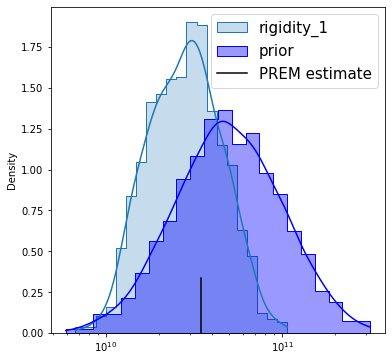

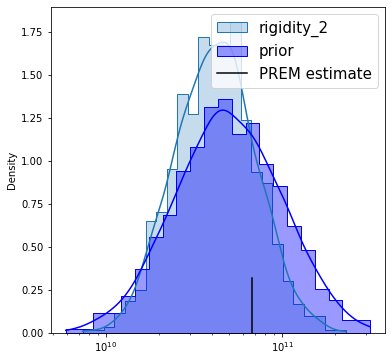

In [ ]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]


# rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
# rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)
# rigidity_prior = 1e11 * pyro.sample("rigidity_prior", dist.Exponential(torch.ones(2000)))
rigidity_prior = pyro.sample(
    "rigidity_prior", dist.LogNormal(logmean * torch.ones(1000), 0.7)
)
for node in nodes:
    plt.figure(figsize=(6, 6))
    g = sns.histplot(
        # 1e11 + 1e10 * samples[node],
        samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        color="blue",
        log_scale=True,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend(fontsize=15)
    plt.xticks(fontsize=10)
    plt.savefig("./ch4_{}_dist.png".format(node), dpi=400)
    plt.show()
    

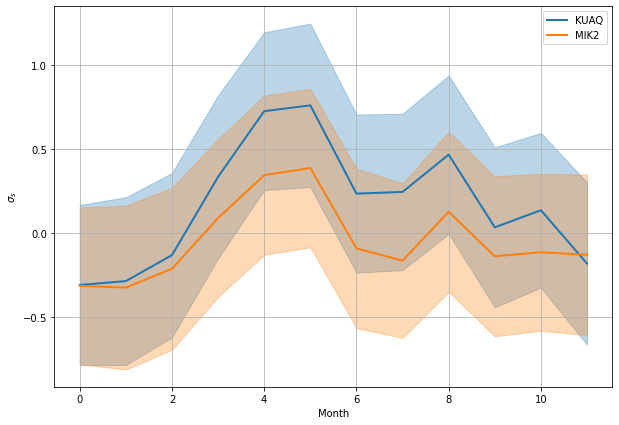

In [ ]:
sigma_s_mu = samples["sigma_s"].mean(axis=0)
sigma_s_std =samples["sigma_s"].std(axis=0)

plt.figure(figsize=(7,7))
plt.plot(sigma_s_mu[:, 0], lw=2, label="KUAQ")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 0] - 2.0 * sigma_s_std[:, 0]).numpy(),
            (sigma_s_mu[:, 0] + 2.0 * sigma_s_std[:, 0]).numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(sigma_s_mu[:, 1], lw=2, label="MIK2")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 1] - 2.0 * sigma_s_std[:, 1]).numpy(),
            (sigma_s_mu[:, 1] + 2.0 * sigma_s_std[:, 1]).numpy(),
            color="C1",
            alpha=0.3,
        )
plt.xlabel("Month", fontsize=10)
plt.ylabel(r"$\sigma_s$", fontsize=10)
plt.legend(fontsize=15)
plt.xticks(fontsize=10)
plt.grid()
plt.savefig("./ch4_seasonality_sigma_s.png", dpi=400)

(2000,)


/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


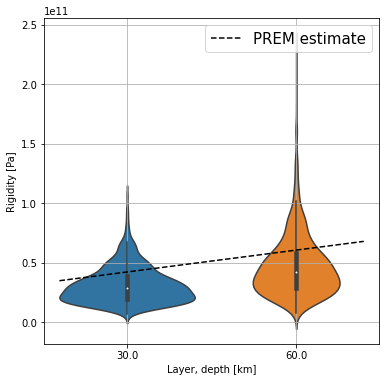

In [ ]:
rigidity_list = []
prem_rigidity_list = [prem_rigidity["rigidity_0"]]
for node in nodes:
    rigidity_list.append(samples[node].numpy())
    prem_rigidity_list.append(prem_rigidity[node])
    
layers = np.hstack((30 * np.ones(1000), 60 * np.ones(1000)))
print(layers.shape)
df_layers = pd.DataFrame(np.array([np.vstack(rigidity_list).squeeze(), layers]).T, 
                         columns=["Rigidity [Pa]", "Layer, depth [km]"])

plt.figure(figsize=(6,6))
sns.violinplot(x = "Layer, depth [km]", y = "Rigidity [Pa]", data = df_layers, fontsize=15)
sns.lineplot([-0.4, 1.4], prem_rigidity_list[1:], color="black", linestyle="--", label="PREM estimate")
plt.grid('minor')
plt.legend(fontsize=15)
plt.savefig("ch3_violin.png", dpi=400)

### Compare to observations

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, x, df_params, mean_v=mean, cov_v=cov, obs=None, df_em=df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

w: (1000, 435, 2)
gf: (1000, 1, 2)


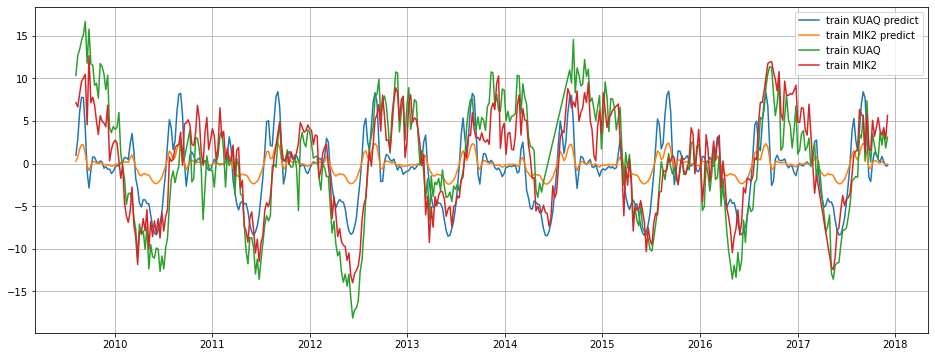

In [ ]:
# pred_k = predictive["gf"].mean(axis=0)[:, 0] * samples["dh"].mean(axis=0)[..., None]
# pred_m = predictive["gf"].mean(axis=0)[:, 1]  * samples["dh"].mean(axis=0)[..., None]
plt.figure(figsize=(16, 6))
# plt.plot(time_train, -2 * pred_k, label="train KUAQ predict")
# plt.plot(time_train, -2 * pred_m, label="train MIK2 predict")
plt.plot(time_train, predictive["w"].mean(axis=0)[:,0].T, label="train KUAQ predict")
plt.plot(time_train, predictive["w"].mean(axis=0)[:,1].T, label="train MIK2 predict")
plt.plot(time_train, y_train[:, 0], label= "train KUAQ")
plt.plot(time_train, y_train[:, 1], label= "train MIK2")
plt.legend()
plt.grid()

In [ ]:
y_hat = predictive["gf"].mean(axis=0) * X_test[:,0].reshape(109,1)

corr, mae, rae, rmse = compute_error(y_test.numpy(), y_hat.numpy())
print("CorrCoef: %.3f\nMAE: %.3f\nRAE: %.3f\nRMSE: %.3f" % (corr, mae, rae, rmse))

CorrCoef: 1.000
MAE: 6.134
RAE: 1.078
RMSE: 7.512


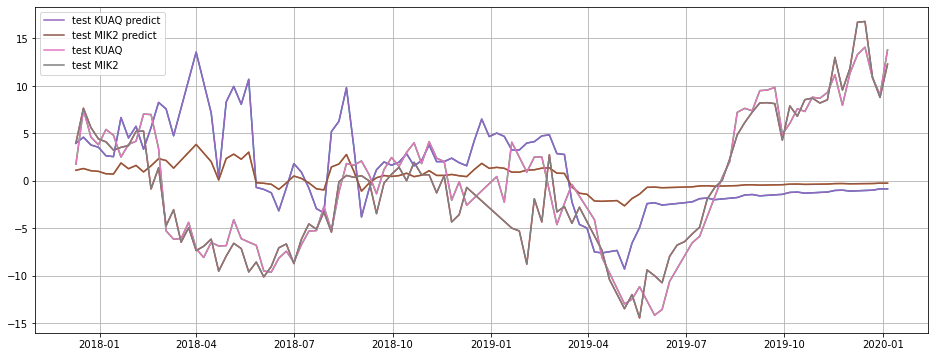

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time_test, y_hat)
plt.plot(time_test, y_test)

plt.plot(time_test, y_hat[:,0], label="test KUAQ predict")
plt.plot(time_test, y_hat[:,1], label="test MIK2 predict")
plt.plot(time_test,y_test[:, 0], label= "test KUAQ")
plt.plot(time_test,y_test[:, 1], label= "test MIK2")
plt.legend()
plt.grid()

In [ ]:
# import dill
# with open('../models/final_model_v1.pkl', 'rb') as f:
# 	mcmc_tmp = dill.load(f)

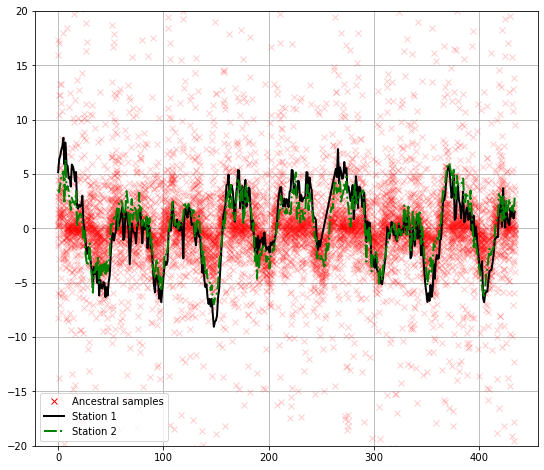

In [ ]:
# plt.figure(figsize=(9, 8))
# for i in range(10):
#     with torch.no_grad():
#         sampling = model(X_train, x, df_params, mean_v=mean, cov_v=cov, obs=None, df_em=df_em)
#         plt.plot(-sampling, marker="x", linestyle="None", alpha=0.2, color="red")
        
# plt.plot(sampling[:, 0], marker="x", linestyle="None", alpha=0.2, color="red", label="Ancestral samples")
# plt.plot(y_train[:, 0], linewidth=2, color="black", label="Station 1")
# plt.plot(y_train[:, 1], linewidth=2, linestyle="-.", color="green", label="Station 2")
# plt.ylim([-20, 20])
# plt.legend()
# ax = plt.gca()
# leg = ax.get_legend()
# leg.legendHandles[0].set_alpha(1)
# plt.grid()
# plt.savefig("./ancestral_sampling.png", dpi=500)